# Denoising Autoencoders (DAE)

The **MNIST dataset** consists of 60,000 images of hand written digit, where each image has size 28X28.

We will define and train a **denoising autoencoder (DAE)** composed of convolutional layers on the MNIST noisy dataset:

<img src="files/figures/mnist.png" width="600px"/>

## 0. Libraries

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## 1. Load data

- The following code loads the MNIST data.
- Note that we don't need any validation set, since we are in an unsupervised setting.

In [2]:
# data
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True,
                            transform=transform)

In [3]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [4]:
# data format
data_iter = iter(train_loader)
images, labels = next(data_iter)
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [5]:
torch.min(images), torch.max(images)

(tensor(0.), tensor(1.))

## 2. Add noise to the data

- The following function adds noise to the data.
- The code below plots a batch of original data and their noisy versions.

In [6]:
def add_noise(images):
    
    return images + 0.5 * torch.randn(*images.shape)

for batch in train_loader:
    break

images = batch[0][:32].squeeze(dim=1) # half of batch (32 items)
images_noisy = add_noise(images).squeeze(dim=1)

images.shape, images_noisy.shape

(torch.Size([32, 28, 28]), torch.Size([32, 28, 28]))

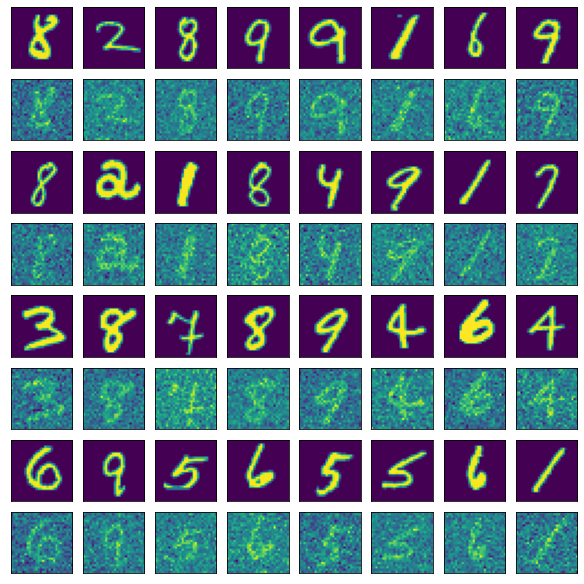

In [7]:
fig, axs = plt.subplots(8, 8, 
                        figsize=(8, 8), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i in range(8):
    
    if i % 2 == 0:
        i2 = i // 2
        samples = images[8*i2:8*i2+8, :, :]
    else:
        i2 = i // 2
        samples = images_noisy[8*i2:8*i2+8, :, :]
    
    for j in range(8):
    
        axs[i, j].imshow(samples[j, :, :])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.savefig('figures/DAE_noisy_data.pdf', format='pdf', bbox_inches='tight')
# plt.show()

## 3. DAE with convolutional layers

### Model

The following class implements a **denoising autoencoder (DAE)** composed of **convolutional layers**.

- Understand the architecture of this **autonecoder (AE)**.

In [11]:
class DenoisingAutoencoder_CNN(nn.Module):
    """Implements a CNN denoising autoencoder"""

    def __init__(self):
        """constructor"""

        super().__init__()

        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            # -> N, 16, 14, 14
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            # -> N, 32, 7, 7
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            # -> N, 64, 1, 1
            nn.Conv2d(32, 64, 7)
            )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            # -> N, 32, 7, 7
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            # N, 16, 14, 14 (N, 16, 13, 13 without output_padding)
            nn.ConvTranspose2d(32, 16, 3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # N, 1, 28, 28 (N,1, 27, 27)
            nn.ConvTranspose2d(16, 1, 3, 
                               stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            )

    def forward(self, x):
        """forward function"""

        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)

        return decoded_data


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

### Training

- Define a **loss** (`MSEloss`) and an **optimizer** (`torch.optim.Adam`) with learning rate `lr=1e-3` for this model.

- Implement a **training loop** for this model during $12$ epochs. 

    Remember that in a **denoising** context, the **training process** of the **autencoder (AE)** works as follows:
    
    1. load a batch of *original images* $\mathbf{X}$
    
    2. add noise to the data to obtain *noisy images* $\mathbf{\tilde X}$
        
    3. process the noisy images $\mathbf{\tilde X}$ in a *forward pass* to obtain *output images* $f(\mathbf{\tilde X})$
    
    4. compute the *loss* between the *output images* $f(\mathbf{\tilde X})$ and the *uncorrupted original images* $\mathbf{X}$
    
    5. apply the *backward pass*
  
  According to this paradigm, the autonecoder learns to denoise the noisy images.<br>
  
  During training, after each epoch, store the current `epoch`, `noisy_inputs`, `outputs` and `train_loss` of the model (in this order) in a list called `outputs_l`.

In [ ]:
model = DenoisingAutoencoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-3, 
                             weight_decay=1e-5)

In [13]:
num_epochs = 20
outputs_l = []

for epoch in range(num_epochs):

    train_loss = []

    for (inputs, _) in train_loader:      # original inputs        (1)

        inputs_noisy = add_noise(inputs)  # noisy inputs
        outputs = model(inputs_noisy)     # outputs (2)
        
        # loss between outputs and original inputs
        loss = criterion(outputs, inputs) # loss between (2) and (1)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = torch.mean(torch.tensor(train_loss)).item()

    print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

    outputs_l.append((epoch, inputs_noisy, outputs, train_loss))

Epoch:1 	 Train loss: 0.0459
Epoch:2 	 Train loss: 0.0164
Epoch:3 	 Train loss: 0.0134
Epoch:4 	 Train loss: 0.0123
Epoch:5 	 Train loss: 0.0118
Epoch:6 	 Train loss: 0.0115
Epoch:7 	 Train loss: 0.0113
Epoch:8 	 Train loss: 0.0111
Epoch:9 	 Train loss: 0.0110
Epoch:10 	 Train loss: 0.0109
Epoch:11 	 Train loss: 0.0108
Epoch:12 	 Train loss: 0.0108
Epoch:13 	 Train loss: 0.0107
Epoch:14 	 Train loss: 0.0107
Epoch:15 	 Train loss: 0.0106
Epoch:16 	 Train loss: 0.0106
Epoch:17 	 Train loss: 0.0106
Epoch:18 	 Train loss: 0.0106
Epoch:19 	 Train loss: 0.0106
Epoch:20 	 Train loss: 0.0105


### Results

- Plot the training loss to confirm that the model has been trained.

- Run the following code which displays the noisy inputs and their reconstructions by the autoencoder at epochs $1$, $12$ and $24$. You shoud see that the autoencoder learns to denoise the noisy inputs as the epochs increase.

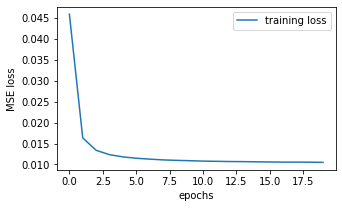

In [15]:
plt.figure(figsize=(5, 3))

epochs = [x[0] for x in outputs_l]
train_loss = [x[3] for x in outputs_l]

plt.plot(epochs, train_loss, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig('figures/DAE_cnn_loss_1.pdf', format='pdf', bbox_inches='tight')
#plt.show()

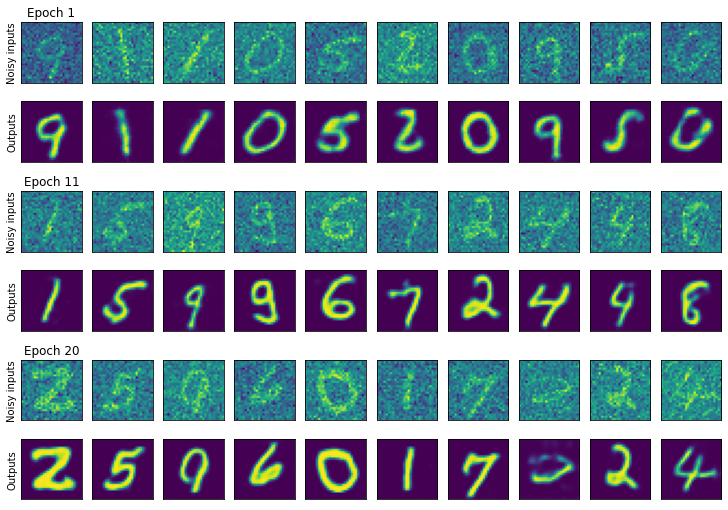

In [16]:
fig, axs = plt.subplots(6, 10, 
                        figsize=(10, 7), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

    inputs = outputs_l[k][1].detach().numpy()
    outputs = outputs_l[k][2].detach().numpy()

    axs[2*i, 0].set_title(f"Epoch {k+1}")
    axs[2*i, 0].set_ylabel("Noisy inputs")

    for j, item in enumerate(inputs):

        if j >= 10: break
        axs[2*i, j].imshow(item[0])
        axs[2*i, j].set_xticks([])
        axs[2*i, j].set_yticks([])

    axs[2*i + 1, 0].set_ylabel("Outputs")
    for j, item in enumerate(outputs):

        if j >= 10: break
        axs[2*i + 1, j].imshow(item[0])
        axs[2*i + 1, j].set_xticks([])
        axs[2*i + 1, j].set_yticks([])

fig.savefig('figures/DAE_cnn_1.pdf', format='pdf', bbox_inches='tight')
# plt.show()

## 4. Noise2Noise Paradigm

Re-implement point 3 in a **noise2noise paradigm**.

- Consider the same **autonecoder (AE)**.

- Define a **loss** (`MSEloss`) and an **optimizer** (`torch.optim.Adam`) with learning rate `lr=1e-3` for this model.

- Implement a **training loop** for this model during $12$ epochs. 

    According to the **noise2noise paradigm**, the **training process** of the **autencoder (AE)** works as follows:
    
    1. load a batch of *original images* $\mathbf{X}$
    
    2. add noise to the data to obtain *noisy images* $\mathbf{\tilde X_1}$
    
    3. re-add noise to the same data to obtain other independent *noisy images* $\mathbf{\tilde X}_2$
        
    3. process the noisy images $\mathbf{\tilde X_1}$ in a *forward pass* to obtain *output images* $f(\mathbf{\tilde X_2})$
    
    4. compute the *loss* between the *output images* $f(\mathbf{\tilde X_1})$ and the *other noisy images* $\mathbf{\tilde X_2}$
    
    5. apply the *backward pass*
  
  Even if it might be counter-intuitive, in this paradigm also, the autonecoder learns to denoise the noisy images.<br>
  
  During training, after each epoch, store the current `epoch`, `noisy_inputs`, `outputs` and `train_loss` of the model (in this order) in a list called `outputs_l`.
  
- Plot the training loss to confirm that the model has been trained.

- Run the following code which displays the noisy inputs and their reconstructions by the autoencoder at epochs $1$, $12$ and $24$. You shoud see that the autoencoder learns to denoise the noisy inputs as the epochs increase.

In [17]:
model = DenoisingAutoencoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-3, 
                             weight_decay=1e-5)

In [18]:
num_epochs = 20
outputs_l = []

for epoch in range(num_epochs):

    train_loss = []

    for (inputs, _) in train_loader:
        
        inputs_noisy1 = add_noise(inputs) # noisy inputs!          (1)
        inputs_noisy2 = add_noise(inputs) # other noisy inputs     
        outputs = model(inputs_noisy2)    # outputs (2)
        
        # loss between noisy inputs and outputs
        loss = criterion(outputs, inputs_noisy1) # loss beween (2) and (1)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = torch.mean(torch.tensor(train_loss)).item()

    print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

    outputs_l.append((epoch, inputs_noisy1, outputs, train_loss))

Epoch:1 	 Train loss: 0.2977
Epoch:2 	 Train loss: 0.2669
Epoch:3 	 Train loss: 0.2642
Epoch:4 	 Train loss: 0.2630
Epoch:5 	 Train loss: 0.2624
Epoch:6 	 Train loss: 0.2621
Epoch:7 	 Train loss: 0.2618
Epoch:8 	 Train loss: 0.2616
Epoch:9 	 Train loss: 0.2615
Epoch:10 	 Train loss: 0.2613
Epoch:11 	 Train loss: 0.2613
Epoch:12 	 Train loss: 0.2611
Epoch:13 	 Train loss: 0.2611
Epoch:14 	 Train loss: 0.2610
Epoch:15 	 Train loss: 0.2610
Epoch:16 	 Train loss: 0.2610
Epoch:17 	 Train loss: 0.2610
Epoch:18 	 Train loss: 0.2608
Epoch:19 	 Train loss: 0.2609
Epoch:20 	 Train loss: 0.2607


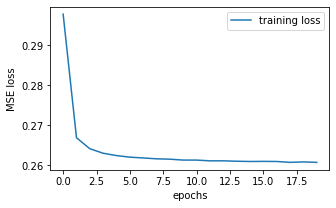

In [19]:
plt.figure(figsize=(5, 3))

epochs = [x[0] for x in outputs_l]
train_loss = [x[3] for x in outputs_l]

plt.plot(epochs, train_loss, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig('figures/DAE_cnn_loss_2.pdf', format='pdf', bbox_inches='tight')
#plt.show()

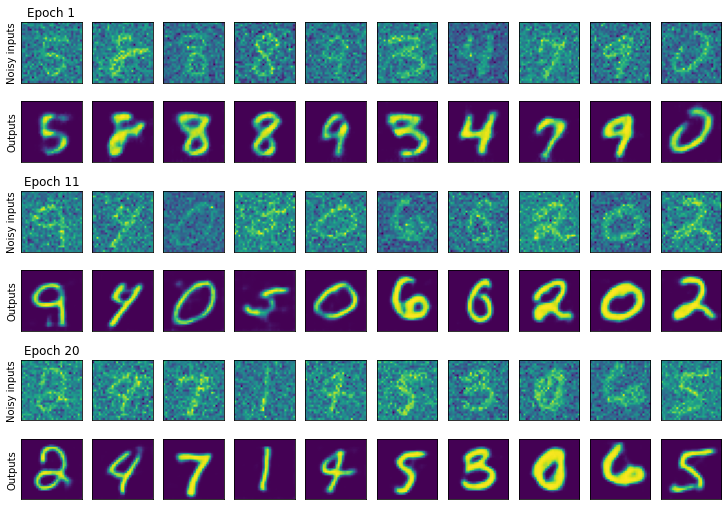

In [20]:
fig, axs = plt.subplots(6, 10, 
                        figsize=(10, 7), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

    inputs = outputs_l[k][1].detach().numpy()
    outputs = outputs_l[k][2].detach().numpy()

    axs[2*i, 0].set_title(f"Epoch {k+1}")
    axs[2*i, 0].set_ylabel("Noisy inputs")

    for j, item in enumerate(inputs):

        if j >= 10: break
        axs[2*i, j].imshow(item[0])
        axs[2*i, j].set_xticks([])
        axs[2*i, j].set_yticks([])

    axs[2*i + 1, 0].set_ylabel("Outputs")
    for j, item in enumerate(outputs):

        if j >= 10: break
        axs[2*i + 1, j].imshow(item[0])
        axs[2*i + 1, j].set_xticks([])
        axs[2*i + 1, j].set_yticks([])

fig.savefig('figures/DAE_cnn_2.pdf', format='pdf', bbox_inches='tight')
# plt.show()

**Conclusion:**
- The DAE can learn to denoise data using clean data as targets.<br>
  In this case the dataset consists of pairs of clean and noisy data $(\mathbf{x}, \mathbf{\tilde x})$. <br>
  During training, the MSE loss between those in minimized.
- The DAE can also learn to denoise data using noisy data as targets.<br>
  In this case the dataset consists of pairs of independent noisy versions $(\mathbf{\bar x}_1, \mathbf{\tilde x}_2)$ of a same unknown data $\mathbf{x}$. <br>
  During training, the MSE loss between those in minimized.